In [1]:
from IPython.display import Image

### IBM Advanced Data Science Capstone Project
#### Salvatore Salpietro

<hr/>

###### Purpose

The scope pf this project is to build a classifier to detect diseased lung from chest x-ray images, where the disease is pneumonia.

###### What is pneumonia

Pneumonia is an inflammatory lung disease that affects the small air sacs called alvioli.  

<img src="https://github.com/erotavlas/machine-learning/raw/main/IBMAdvancedDataScience_Capstone/images/pneumonia.jpg" width=350 />

###### Types
There are three main classification of pneumonia by location in the lungs, these are,

- Lobar and Multilobar pneumonia is an infection that involves one or more lobes, or section, of a lung. Lobar pneumonia is often due to Streptococcus pneumoniae (though Klebsiella pneumoniae is also possible.) Multilobar pneumonia involves more than one lobe, and it often causes a more severe illness.
- Bronchial pneumonia affects the lungs in patches around the tubes (bronchi or bronchioles).
- Interstitial pneumonia involves the areas in between the alveoli, and it may be called "interstitial pneumonitis." It is more likely to be caused by viruses or by atypical bacteria.

<img src="https://github.com/erotavlas/machine-learning/raw/main/IBMAdvancedDataScience_Capstone/images/types-of-pneumonia.jpeg" width=350 />

###### Symptoms
People with this condition typically exhibit the following symptoms of variable severity 
- cough 
- chest pain 
- fever 
- difficulty breathing. 

###### Causes
The causes are mainly due to viruses and bacteris but can also be from fungii, parasites or noninfectious causes.  

<img src="https://github.com/erotavlas/machine-learning/raw/main/IBMAdvancedDataScience_Capstone/images/causes.jpg" width=500>

###### Diagnosis
In order to verify a case of pneumonia in a patient, doctors rely on a combination of methods including observing physical signs, blood tests, and often a chest X-ray.  The chest X-ray is useful not only for diagnosis, but also to determine the extent of disease in the lungs.  

###### How does a doctor determine if a lung is diseased or not from chest X-rays?  
A chest X-ray is a radiology test that involves exposing the chest briefly to radiation to produce an image of the chest and the internal organs of the chest. An X-ray film is positioned against the body opposite the camera, which sends out a very small dose of a radiation beam. As the radiation penetrates the body, it is absorbed in varying amounts by different body tissues depending on the tissue's composition of air, water, blood, bone, or muscle. The X-ray image records these difference in penetration of the X-ray beam to produce an image of body tissue structures. The white shadows on chest X-ray represent areas where the beam is blocked by more dense or solid tissues, such as bone or heart.  The darker shadows on the chest X-ray represent areas where the x-ray beam penetrates more easily such as in air filled tissues like the lungs. 

Here is an example of chest x-rays for normal lung vs lung affected by pneumonia.
<img src="https://github.com/erotavlas/machine-learning/raw/main/IBMAdvancedDataScience_Capstone/images/normal_vs_pneumonia.png" width=500 />

Doctors look for lighter areas in the lung indicating the precense of inflammation and fluid buildup.  This causes areas of the lung to become lighter on the x-ray image compared to the darker air filled areas of healthy lungs.

###### Can AI assist in this process?
In this project we will attempt to create a machine learning model that will effectively automate what the doctor is doing when they screen a patient for lung disease, in this case the disease is pneumonia. By training the model on a set of healthy and diseased lung X-ray images, it will be able to distinguish between the two types.

### Importing libraries

In [149]:
from skimage import io # allows to read images
from matplotlib import pyplot
from pathlib import Path
from natsort import natsorted, ns # natural sorting
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm, metrics
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import validation_curve

import numpy as np
import pandas as pd
import statistics
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [3]:
print(tf.__version__)

2.4.0


### Data analysis step

Determine the characteristics of the data and statistics 

#### 1. Data source

Data was obtained from the following source 
https://data.mendeley.com/datasets/rscbjbr9sj/3

We are provided with an archive file containing a set of chest x-rays.  Images are provided in two separate folders, test and train.  Within those folders images are separated into two classes - normal and pneumonia.  

```text
chest-xray
|__test
|  |__NORMAL
|  |__PNEUMONIA
|
|__train
   |__NORMAL
   |__PNEUMONIA```

#### 2. Characteristics of files

In [4]:
sizes = [] # sizes in kb
all_extensions = set([])
filenum = []
count = 0

test_images = []
test_labels = []

train_images = []
train_labels = []

# training set folder
for root, dirs, files in os.walk("E:\COURSES\Advanced Data Science With IBM\Advanced Data Science Capstone\\assignment\data\chest_xray\\train"):
    #print('dirs', dirs)
    for name in files:
        #print('name', name)
        #print(os.path.basename(root))
        
        file_name, file_extension = os.path.splitext(name)
        all_extensions.add(file_extension)
        
        stats = os.stat(os.path.join(root, name))
        count = count + 1
        
        sizes.append(stats.st_size/1000) 
        
        #if(stats.st_size/1000 < 12):
        #    discarded.append(os.path.join(root, name))
        #else:
        train_images.append(os.path.join(root, name))
        train_labels.append(os.path.basename(root))
        
        filenum.append(count)

# test set folder
for root, dirs, files in os.walk("E:\COURSES\Advanced Data Science With IBM\Advanced Data Science Capstone\\assignment\data\chest_xray\\test"):
    #print('dirs', dirs)
    for name in files:
        #print('name', name)
        #print(os.path.basename(root))
        
        file_name, file_extension = os.path.splitext(name)
        all_extensions.add(file_extension)

        stats = os.stat(os.path.join(root, name))
        count = count + 1
        
        sizes.append(stats.st_size/1000)
        
        #if(stats.st_size/1000 < 12):
        #    discarded.append(os.path.join(root, name))
        #else:
        test_images.append(os.path.join(root, name))
        test_labels.append(os.path.basename(root))
        
        filenum.append(count)

##### 2.1. File names

File names for images of dieases lungs contain a unique anonymized person number as well as the text 'bacteris' or 'virus' indicating if the pnemonia was caused by a virus or bacteris.  Example person426_virus_873

File names for images of normal lungs contain the work 'NORMAL'. Example - NORMAL2-IM-1250-0001

##### 2.2. File extensions

In [5]:
print(all_extensions)

{'.png', '.jpeg'}


Files are of types - png and jpeg

##### 2.3. Total number of image files

In [6]:
total_image_files = len(train_images) + len(test_images)

In [7]:
print(total_image_files)

7197


There are a total of 7197 files across both folders (test and train)

##### 2.4. Distribution of image files in test and train folders

In [8]:
len(test_images)

624

In [9]:
len(train_images)

6573

In [10]:
print('Train / Test split is about ', len(train_images) / total_image_files * 100, ' / ', 100 - len(train_images) / total_image_files * 100) 

Train / Test split is about  91.3297207169654  /  8.670279283034603


##### 2.5 Class distribution for training set

In [11]:
pneumonia = [i for i in train_labels if i == 'PNEUMONIA']
normal = [i for i in train_labels if i == 'NORMAL']

In [12]:
len(normal)

2690

In [13]:
len(pneumonia)

3883

In [14]:
print('There are ', len(pneumonia)/len(normal), ' more pneumonia images than normal images in the training set')

There are  1.4434944237918215  more pneumonia images than normal images in the training set


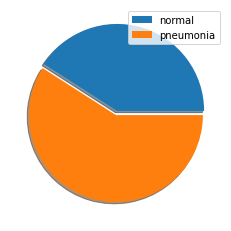

In [15]:
y = [2690, 3883]
l = ["normal", "pneumonia"]
explode = (0.05, 0)  # explode 1st slice
patches, texts = plt.pie(y, explode=explode,  shadow=True )
plt.legend(patches, l, loc="best")
plt.show() 

#### 4. Size of the images

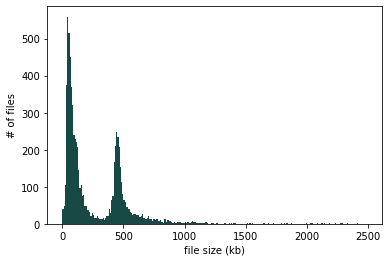

In [16]:

b = [i for i in range(0,2500,10)]

plt.xlabel('file size (kb)')
plt.ylabel('# of files')
plt.hist(sizes, bins=b,  color='#184A45FF')
plt.show()

Above is a histogram plot to show the ditribution of file sizes.  Most of the files are of size less than 1000 kb.

In [17]:
avg = sum(sizes)/len(sizes)
print(avg)

256.44553591774263


In [18]:
print(statistics.median(sizes))

125.716


In [19]:
print(min(sizes))

5.441


In [20]:
print(max(sizes))

2414.342


The mean file size is 211.148

The median file size is 95.839

The minimum file size observed is 5.441 kb

The maximum file size observed is 2412.342 kb

Sonce the file sizes are not all the same, some examination of the really small ans really large image files revealed that the really small images aspect ratio did not match those of the majority of images (i.e. they were longer in width than height and did not reveal the full chest/lung view).  These images might be considered outliers.  Further examination of the images below will attempt to exclude such outliers.  

#### 4. Aspect ratio of the images

The aspect ratio of an image is the ratio of its width to its height.
The formula is width / height.

Not all the images are of the same aspect ratio. On examining some of the images of smaller size, some did not show the full view of the chest and lungs.  We will remove these images.

If the shape of the image is longer in the x axis than it is in the y axis by certain threshold, then discard those images as they only show a section of the full chest image.

Choose something x/y must be less than or equal to 2 to constitute an acceptible image. (i.e. if the width is two or more times longer than the height then discard image)

In [21]:
temp_train_images = []
temp_train_labels = []

temp_test_images = []
temp_test_labels = []

discarded = []

for i in range(len(train_images)):
    xray = io.imread(train_images[i])
    y = xray.shape[0]
    x = xray.shape[1]
    ratio = x/y
    if ratio <= 2:
        temp_train_images.append(train_images[i])
        temp_train_labels.append(train_labels[i])
    else:
        discarded.append(train_images[i])
        
for i in range(len(test_images)):
    xray = io.imread(test_images[i])
    y = xray.shape[0]
    x = xray.shape[1]
    ratio = x/y
    if ratio <= 2:
        temp_test_images.append(test_images[i])
        temp_test_labels.append(test_labels[i])
    else:
        discarded.append(test_images[i])

In [22]:
print('updated train set, labels ', len(temp_train_images), len(temp_train_labels))
print('updated test set, labels ', len(temp_test_images), len(temp_test_labels))
print('discarded images ', len(discarded))

updated train set, labels  6457 6457
updated test set, labels  614 614
discarded images  126


Compare a discarded image to a remaining image in train set.

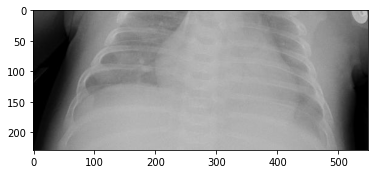

(229, 549, 3)


In [23]:
import matplotlib.pyplot as plt
im = io.imread(discarded[35])
imgplot = plt.imshow(im, cmap="gray")
plt.show()
print(im.shape)

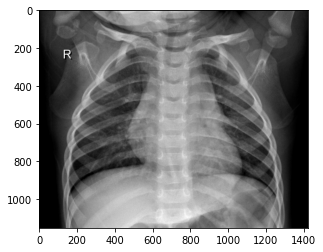

(1152, 1422)


In [24]:
im = io.imread(temp_train_images[1])
imgplot = plt.imshow(im, cmap="gray")
plt.show()
print(im.shape)

#### 4. Redistribute data to a train/validation / test split of 85/15/15

Now that the outliers have been removed, we can redistribute the data set to add some more images to the test set to bring the value up to 15%, and then split the remaining test set into a test and validation split of 85/15.

We won't touch the images in the test set, rather we will simply move some of the ones from the train set into the test set.

Using 15% instead of 20% because we son't have that many images to work with.

In [25]:
# new ratios after removing some outliers

total = len(temp_train_images) + len(temp_test_images)
print('total images = ', total)

percent_test = len(temp_test_images)/total
print('percent test ', percent_test*100)

percent_train = len(temp_train_images)/total
print('percent train ', percent_train*100)

total images =  7071
percent test  8.683354546740206
percent train  91.3166454532598


In [26]:
# calculate number of images to move from train set to test set

needed = 0.15*total
print(needed)

have = len(temp_test_images)
print(have)

difference = needed - have
print("need to add an additional ", difference, " images")

1060.6499999999999
614
need to add an additional  446.64999999999986  images


In [27]:
# convert to pandas dataframe

# train set
data_train = {'file':temp_train_images,'label':temp_train_labels}
train_df = pd.DataFrame(data_train)

# test set
data_test = {'file':temp_test_images,'label':temp_test_labels}
test_df = pd.DataFrame(data_test)

In [28]:
train_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
2,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
3,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
4,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
...,...,...
6452,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
6453,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
6454,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
6455,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


In [29]:
train_df['file'][2000], train_df['label'][2000]

('E:\\COURSES\\Advanced Data Science With IBM\\Advanced Data Science Capstone\\assignment\\data\\chest_xray\\train\\NORMAL\\NORMAL2-IM-0460-0001.jpeg',
 'NORMAL')

In [30]:
test_df['file'][200], test_df['label'][200]

('E:\\COURSES\\Advanced Data Science With IBM\\Advanced Data Science Capstone\\assignment\\data\\chest_xray\\test\\NORMAL\\NORMAL2-IM-0340-0001.jpeg',
 'NORMAL')

In [31]:
# first shuffle rows in train dataframe
train_df = train_df.sample(n = len(train_df), random_state=200).reset_index(drop=True)

In [32]:
# then move 245 rows from train dataframe to test dataframe
transferdata_df = train_df.iloc[-446:, 0:]

test_df = test_df.append(transferdata_df)

train_df = train_df.drop(transferdata_df.index)

In [33]:
# reset index of test_df
test_df = test_df.reset_index(drop=True)

In [34]:
train_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
2,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
4,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
...,...,...
6006,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
6007,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
6008,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
6009,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


In [35]:
test_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
2,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
3,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
4,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
...,...,...
1055,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
1056,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
1057,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1058,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


In [36]:
# split train set further into train and validation set

newtrain_df = train_df.sample(frac=0.85,random_state=200) #random state is a seed value
validation_df = train_df.drop(newtrain_df.index)

In [37]:
train_df = newtrain_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

In [38]:
train_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
1,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
2,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
3,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
4,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
...,...,...
5104,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
5105,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
5106,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
5107,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


In [39]:
validation_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
2,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
...,...,...
897,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
898,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
899,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
900,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


We now have three data sets
- train_df (training set)
- validation_df (validation set)

- test_df (final test set)

#### 5. Shape and color of images

In [40]:
# Retrieving the geometry of the image and the number of pixels
# Images in scikit-image are represented by NumPy ndarrays. 
# Hence, many common operations can be achieved using standard NumPy methods for manipulating arrays

x = []
y = []
z = []
listofdataframes = [train_df, validation_df, test_df]

for df in listofdataframes:
    for index, row in df.iterrows():
        image = row['file']
        s = io.imread(image)
        x.append(s.shape[0])
        y.append(s.shape[1])
        if(len(s.shape) == 3):
            z.append(1)
        else:
            z.append(0)

In [41]:
df = pd.DataFrame({'x': x,
                   'y': y,
                   'z': z})

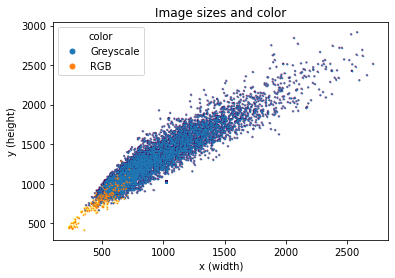

In [42]:
area = 2
plt.scatter(x, y, c=df.z, s=area,  alpha=0.5)
plt.title('Image sizes and color')
plt.xlabel('x (width)')
plt.ylabel('y (height)')
classes = [ 'Greyscale', 'RGB']
groups = df.groupby('z')
for name, group in groups:
    name = classes[0] if name == 0 else classes[1]
    plt.plot(group.x, group.y, marker='.', linestyle='', markersize=1, label=name)

plt.legend(title="color", markerscale=10)

plt.show()

 Since all the images are of different sizes, it will be necessary to reshape them to the same size.
 Also some are greyscale while other are RGB, so it will be necessary to normalize all images to the same color space (greyscale) 

## Data Preprocessing

The following steps need to be done in the data preprocessing step


We perform a grayscale normalization to reduce the effect of illumination's differences.
Divide values by 255 to get a value between 0 and 1. 

#### Image Resize
images need to be resized to the same size - both training and test set

NOTE: this step will be done within train_datagen.flow_from_dataframe function by setting parameter 'target_size'

This is an example using skimage (we are not using this here)

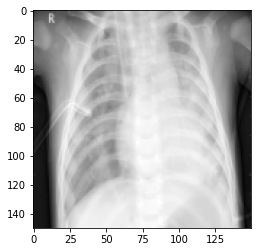

(150, 150)


In [43]:
from skimage.transform import resize
img = io.imread(train_df['file'][0])
img_rescaled = resize(img, (150,150))

imgplot = plt.imshow(img_rescaled, cmap="gray")
plt.show()
print(img_rescaled.shape)

### Image Augmentation Step

In order to avoid overfitting problem, alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

#### 1. Preprocessing the Training Set

Transformation on the images of the training set to avoid overfitting (data augmentation - see above)

Randomly zoom by max 5% (zoom will vary randomly between 0 and 5%)

Randomly shift images horizontally by max 5% of the width

Randomly shift images vertically by max 5% of the height

Randomly flip images horizontally. 


rescale=1./255 divides all the pixels by 255 so they end up between 0 and 1 - normalization

In [44]:
#train_datagen = ImageDataGenerator(
#        rescale=1./255,
#        zoom_range=0.1,
#        horizontal_flip=True,
#        width_shift_range=0.1,
#        height_shift_range=0.1)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        width_shift_range=0.05,
        height_shift_range=0.05)

In [45]:
train_set = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col="file",
    y_col="label",
    weight_col=None,
    target_size=(128, 128),
    color_mode="grayscale",
    classes=None,
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=200,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
)

Found 5109 validated image filenames belonging to 2 classes.


#### 2. Preprocesing the validation and test set

Here we need to keep the images as they were with no modifications but we have to feature scale the images to match the feature scaling done to the test images.

In [46]:
test_datagen = ImageDataGenerator(
        rescale=1./255
        )

In [47]:
validation_datagen = ImageDataGenerator(
        rescale=1./255
        )

In [48]:
validation_set = validation_datagen.flow_from_dataframe(
    validation_df,
    directory=None,
    x_col="file",
    y_col="label",
    weight_col=None,
    target_size=(128, 128),
    color_mode="grayscale",
    classes=None,
    class_mode="binary",
    batch_size=32,
    shuffle=False,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
)

Found 902 validated image filenames belonging to 2 classes.


In [49]:
test_set = test_datagen.flow_from_dataframe(
    test_df,
    directory=None,
    x_col="file",
    y_col="label",
    weight_col=None,
    target_size=(128, 128),
    color_mode="grayscale",
    classes=None,
    class_mode="binary",
    batch_size=32,
    shuffle=False,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
)

Found 1060 validated image filenames belonging to 2 classes.


###  Calculate class weights

We will use the class_weights to correct for class imbalance to avoid a bias towards the majority class.

Formula to calculate the weight for a class

wj=n_samples / (n_classes * n_samplesj)

wj is the weight for class j

n_samples is the total number of samples or rows in the dataset

n_classes is the total number of unique classes in the target

n_samplesj is the total number of rows of the respective class

In [50]:
pneumonia_df = train_df.loc[train_df['label'] == 'PNEUMONIA']
print(pneumonia_df)

normal_df = train_df.loc[train_df['label'] == 'NORMAL']
print(normal_df)

                                                   file      label
0     E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA
1     E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA
4     E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA
5     E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA
6     E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA
...                                                 ...        ...
5101  E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA
5103  E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA
5104  E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA
5106  E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA
5107  E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA

[3006 rows x 2 columns]
                                                   file   label
2     E:\COURSES\Advanced Data Science With IBM\Adva...  NORMAL
3     E:\COURSES\Advanced Data Science With

In [51]:
n_samples = len(train_df)
n_classes = 2
n_pneumonia = len(pneumonia_df)
n_normal = len(normal_df)

w_pneumonia = n_samples/(n_classes*n_pneumonia)
w_normal = n_samples/(n_classes*n_normal)

print("Number of pneumonia ", n_pneumonia, " and Number of normal ", n_normal)
print("weights: pneumonia = ", w_pneumonia, ", normal = ", w_normal)

# get the class indices

print(train_set.class_indices)

# assign the class weights calculated above
# we will use this in the fit() method below

class_weight = {0: w_normal, 1: w_pneumonia}


Number of pneumonia  3006  and Number of normal  2103
weights: pneumonia =  0.8498003992015968 , normal =  1.2146932952924394
{'NORMAL': 0, 'PNEUMONIA': 1}


### Get Data for scikit learn

In [52]:
x_tr = []
y_tr = []

batches = 0

for inputs,outputs in tqdm(train_set):   
    batches += 1
    for i in range(len(inputs)):
        flat = inputs[i].flatten()
        x_tr.append(flat)
        y_tr.append(outputs[i])
    
    if batches >= len(train_df) / 32:
    # we need to break the loop by hand because
    # the generator loops indefinitely
        break

 99%|███████████████████████████████████████████████████████████████████████████████▌| 159/160 [00:29<00:00,  5.47it/s]


In [53]:
x_val = []
y_val = []

batches = 0

for inputs,outputs in tqdm(validation_set):   
    batches += 1
    for i in range(len(inputs)):
        flat = inputs[i].flatten()
        x_val.append(flat)
        y_val.append(outputs[i])
    
    if batches >= len(validation_df) / 32:
    # we need to break the loop by hand because
    # the generator loops indefinitely
        break

 97%|███████████████████████████████████████████████████████████████████████████████▏  | 28/29 [00:04<00:00,  6.02it/s]


In [54]:
x_test = []
y_test = []

batches = 0

for inputs,outputs in tqdm(test_set):   
    batches += 1
    for i in range(len(inputs)):
        flat = inputs[i].flatten()
        x_test.append(flat)
        y_test.append(outputs[i])
    
    if batches >= len(test_df) / 32:
    # we need to break the loop by hand because
    # the generator loops indefinitely
        break

 97%|███████████████████████████████████████████████████████████████████████████████▌  | 33/34 [00:04<00:00,  8.07it/s]


## Baseline Model

In [81]:
# dictionary to hold fpr and tpr

roc = {}

In [55]:
clf_baseline = DummyClassifier(strategy="stratified")
clf_baseline.fit(x_tr, y_tr)

DummyClassifier(strategy='stratified')

confusion matrix
[[152 247]
 [212 291]]


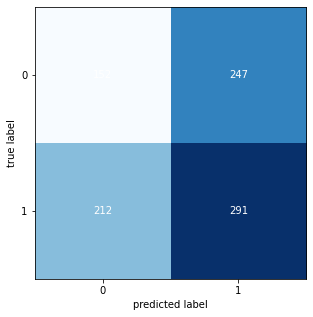

In [56]:
pred_baseline = clf_baseline.predict_proba(x_val)
CM_baseline = confusion_matrix(validation_set.classes, np.argmax(pred_baseline, axis=1))
print("confusion matrix")
print(CM_baseline)
fig, ax = plot_confusion_matrix(conf_mat=CM_baseline ,  figsize=(5, 5))
plt.show()

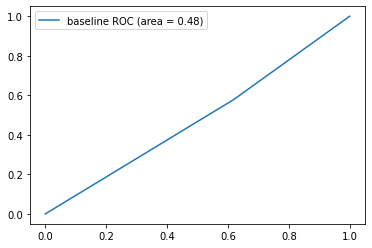

In [82]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, pred_baseline[:,1])
auc = metrics.roc_auc_score(y_val,pred_baseline[:,1])
roc['baseline'] = [fpr,tpr,auc]

plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('baseline', auc))
plt.legend(loc=0)

### Naive Bayes Classifier

In [58]:

clf_naive = GaussianNB().fit(x_tr, y_tr)
pred_naive = clf_naive.predict_proba(x_val)

In [59]:
pred_naive_ = np.argmax(pred_naive, axis=1)

confusion matrix
[[367  32]
 [118 385]]


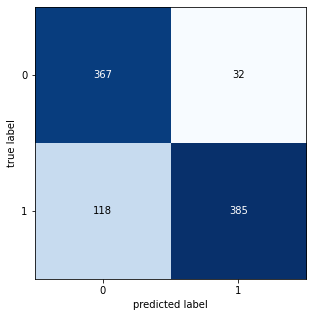

In [60]:
CM_naive = confusion_matrix(validation_set.classes, pred_naive_)
print("confusion matrix")
print(CM_naive)
fig, ax = plot_confusion_matrix(conf_mat=CM_naive ,  figsize=(5, 5))
plt.show()

In [83]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, pred_naive[:,1])
auc = metrics.roc_auc_score(y_val,pred_naive[:,1])
roc['naive bayes'] = [fpr,tpr,auc]

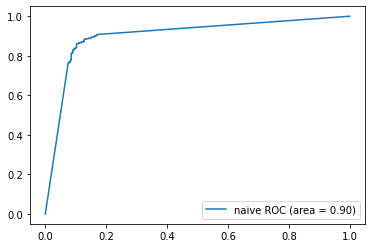

In [62]:
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('naive', auc))
plt.legend(loc=0)

### Random Forest Classifier

In [63]:
clf_randomforest = RandomForestClassifier(max_depth=2, random_state=0)

In [64]:
clf_randomforest.fit(x_tr, y_tr)

RandomForestClassifier(max_depth=2, random_state=0)

In [65]:
pred_randomforest = clf_randomforest.predict_proba(x_val)

In [66]:
print(classification_report(y_val, np.argmax(pred_randomforest, axis=1)))

              precision    recall  f1-score   support

         0.0       0.74      0.84      0.79       399
         1.0       0.86      0.77      0.81       503

    accuracy                           0.80       902
   macro avg       0.80      0.80      0.80       902
weighted avg       0.81      0.80      0.80       902



confusion matrix
[[335  64]
 [118 385]]


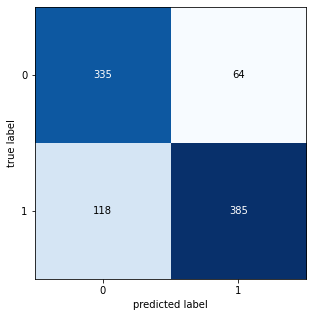

In [67]:
CM_rfc = confusion_matrix(validation_set.classes, np.argmax(pred_randomforest, axis=1))
print("confusion matrix")
print(CM_rfc)

fig, ax = plot_confusion_matrix(conf_mat=CM_rfc ,  figsize=(5, 5))
plt.show()

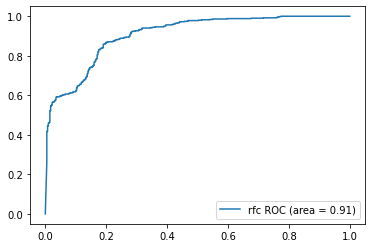

In [84]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, pred_randomforest[:,1])
auc = metrics.roc_auc_score(y_val,pred_randomforest[:,1])
roc['random forest'] = [fpr,tpr,auc]

plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('rfc', auc))
plt.legend(loc=0)

### Support Vector Machine

In [88]:

clf_svm = svm.SVC()
clf_svm.fit(x_tr, y_tr)

SVC()

In [89]:
pred_svm = clf_svm.predict(x_val)

In [90]:
p = np.array(clf_svm.decision_function(x_val))

In [91]:
prob = np.exp(p)/np.sum(np.exp(p), keepdims=True)

In [92]:
print(classification_report(y_val, pred_svm))

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94       399
         1.0       0.97      0.93      0.95       503

    accuracy                           0.94       902
   macro avg       0.94      0.95      0.94       902
weighted avg       0.94      0.94      0.94       902



confusion matrix
[[383  16]
 [ 35 468]]


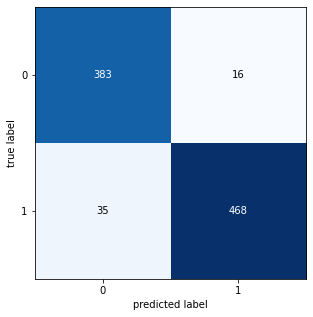

In [93]:
CM_svm = confusion_matrix(validation_set.classes, pred_svm)
print("confusion matrix")
print(CM_svm)

fig, ax = plot_confusion_matrix(conf_mat=CM_svm ,  figsize=(5, 5))
plt.show()

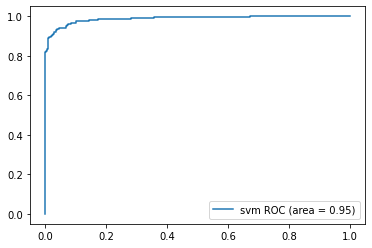

In [94]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, prob)
auc = metrics.roc_auc_score(y_val,pred_svm)
roc['svm'] = [fpr,tpr,auc]

plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('svm', auc))
plt.legend(loc=0)

### Plot combined ROC curves

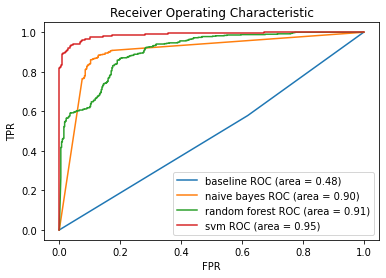

In [95]:
for key, value in roc.items():
    plt.plot(value[0], value[1], label='%s ROC (area = %0.2f)' % (key, value[2]))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

In [ ]:
param_range = np.logspace(-6, -1, 5)
train_scores, valid_scores = validation_curve(svm.SVC(), x_tr, y_tr, param_name="gamma", param_range=param_range, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

## Deep Neural Nets

### Define Metrics

In [135]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]

### Building CNN-1

In [136]:
cnn_1 = tf.keras.models.Sequential()
#cnn_1.add(tf.keras.layers.Cropping2D(cropping=((8, 8), (8, 8)), input_shape=(256,256,1)))

#### 1. Convolution and Pooling

In [137]:
#cnn_1.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu' ))
cnn_1.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=(128,128,1) ))

cnn_1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding = 'same'))

#### 3. Add a additional Convolutional and Pooling Layer

In [138]:
#cnn.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, activation='relu'))
#cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding = 'same'))

cnn_1.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))
cnn_1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding = 'same'))

cnn_1.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
cnn_1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding = 'same'))

#### 4. Flattening

In [139]:
cnn_1.add(tf.keras.layers.Flatten())

#### 5. Full Connection

In [140]:
#units = number of hidden neurons - larger number better for images
cnn_1.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn_1.add(tf.keras.layers.Dropout(0.5))

#### 6. Output Layer

In [141]:
#units = 1 for binary classification
cnn_1.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

#### 7. Compiling the CNN

In [142]:
cnn_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
cnn_1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 126, 126, 8)       80        
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 63, 63, 8)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 61, 61, 32)        2336      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 14400)            

### Building CNN-2

In [143]:
cnn_2 = tf.keras.models.Sequential()
#cnn_2.add(tf.keras.layers.Cropping2D(cropping=((8, 8), (8, 8)), input_shape=(256,256,1)))
cnn_2.add(tf.keras.layers.Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', input_shape=(128,128,1) ))

cnn_2.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_2.add(tf.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn_2.add(tf.keras.layers.Dropout(0.1))

cnn_2.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_2.add(tf.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))

cnn_2.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_2.add(tf.keras.layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn_2.add(tf.keras.layers.Dropout(0.2))

cnn_2.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_2.add(tf.keras.layers.Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn_2.add(tf.keras.layers.Dropout(0.2))

cnn_2.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_2.add(tf.keras.layers.Flatten())
cnn_2.add(tf.keras.layers.Dense(units = 128 , activation = 'relu'))
cnn_2.add(tf.keras.layers.Dropout(0.2))
cnn_2.add(tf.keras.layers.Dense(units = 1 , activation = 'sigmoid'))
cnn_2.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = METRICS)
cnn_2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
dropout_17 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 16, 16, 64)       

#### 3.1 Training CNN-1

In [144]:
# NOTE - cannot use the validation_split when using data set generators so need to split the dataframe manually
# into train and validation set. This was done above

#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode="min", patience=3, restore_best_weights=True)
#history = cnn.fit(x = train_set, class_weight=class_weight, validation_data = validation_set, epochs=100, callbacks=[callback] )
history_cnn_1 = cnn_1.fit(x = train_set, class_weight=class_weight, validation_data = validation_set, epochs=25 )

Epoch 1/25
160/160 [==============================] - 34s 206ms/step - loss: 0.5210 - accuracy: 0.7127 - precision: 0.7988 - recall: 0.6518 - auc: 0.8018 - val_loss: 0.1582 - val_accuracy: 0.9346 - val_precision: 0.9269 - val_recall: 0.9583 - val_auc: 0.9847
Epoch 2/25
160/160 [==============================] - 33s 203ms/step - loss: 0.1797 - accuracy: 0.9307 - precision: 0.9503 - recall: 0.9295 - auc: 0.9800 - val_loss: 0.1286 - val_accuracy: 0.9512 - val_precision: 0.9732 - val_recall: 0.9384 - val_auc: 0.9907
Epoch 3/25
160/160 [==============================] - 33s 204ms/step - loss: 0.1725 - accuracy: 0.9375 - precision: 0.9578 - recall: 0.9358 - auc: 0.9809 - val_loss: 0.1085 - val_accuracy: 0.9612 - val_precision: 0.9699 - val_recall: 0.9602 - val_auc: 0.9926
Epoch 4/25
160/160 [==============================] - 33s 204ms/step - loss: 0.1553 - accuracy: 0.9379 - precision: 0.9645 - recall: 0.9285 - auc: 0.9850 - val_loss: 0.1019 - val_accuracy: 0.9579 - val_precision: 0.9568 - v

#### 3.2 Train CNN-2

In [145]:
history_cnn_2 = cnn_2.fit(x = train_set, class_weight=class_weight, validation_data = validation_set, epochs=25 )

Epoch 1/25
160/160 [==============================] - 35s 211ms/step - loss: 0.5806 - accuracy: 0.5998 - precision: 0.8824 - recall: 0.6402 - auc: 0.8843 - val_loss: 0.1547 - val_accuracy: 0.9479 - val_precision: 0.9524 - val_recall: 0.9543 - val_auc: 0.9891
Epoch 2/25
160/160 [==============================] - 33s 205ms/step - loss: 0.2246 - accuracy: 0.9151 - precision: 0.9419 - recall: 0.9076 - auc: 0.9685 - val_loss: 0.1162 - val_accuracy: 0.9523 - val_precision: 0.9772 - val_recall: 0.9364 - val_auc: 0.9922
Epoch 3/25
160/160 [==============================] - 33s 205ms/step - loss: 0.1192 - accuracy: 0.9546 - precision: 0.9790 - recall: 0.9414 - auc: 0.9902 - val_loss: 0.1623 - val_accuracy: 0.9346 - val_precision: 0.9978 - val_recall: 0.8847 - val_auc: 0.9934
Epoch 4/25
160/160 [==============================] - 33s 206ms/step - loss: 0.1472 - accuracy: 0.9439 - precision: 0.9705 - recall: 0.9334 - auc: 0.9858 - val_loss: 0.1215 - val_accuracy: 0.9523 - val_precision: 0.9978 - v

### Evaluating

#### 1. Examine the loss and accuracy curves

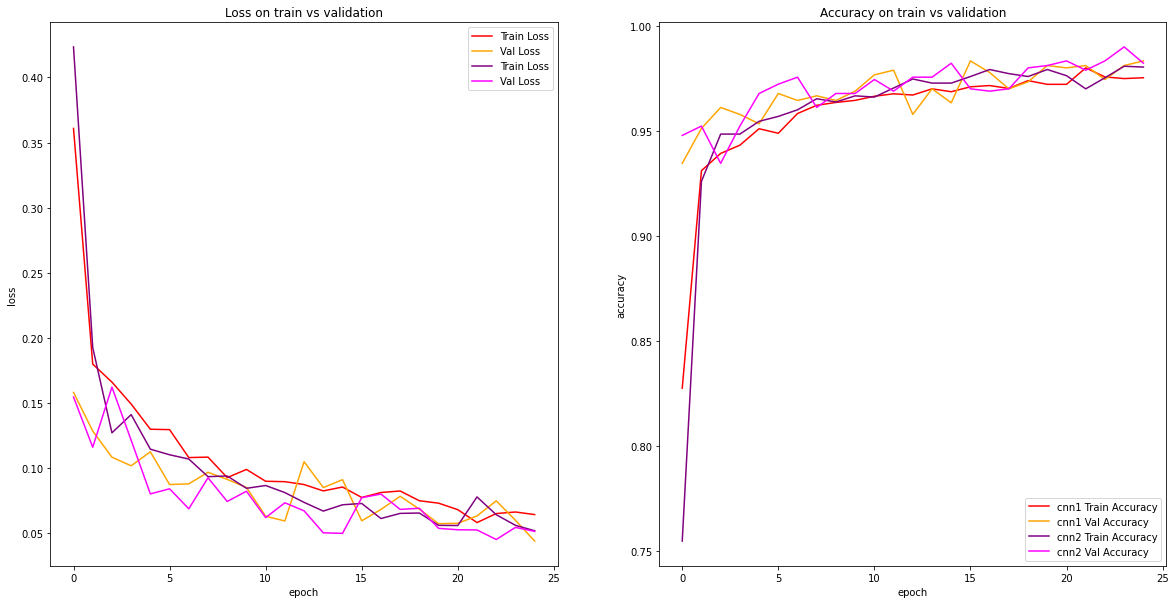

In [146]:
plt.figure(figsize=(20,10))

# plot loss & val loss
plt.subplot(1,2,1)

# cnn-1
sns.lineplot(x=history_cnn_1.epoch, y=history_cnn_1.history['loss'], color='red', label='Train Loss')
sns.lineplot(x=history_cnn_1.epoch, y=history_cnn_1.history['val_loss'], color='orange', label='Val Loss')
# cnn-2
sns.lineplot(x=history_cnn_2.epoch, y=history_cnn_2.history['loss'], color='purple', label='Train Loss')
sns.lineplot(x=history_cnn_2.epoch, y=history_cnn_2.history['val_loss'], color='magenta', label='Val Loss')

#plt.ylim(0, 3)
plt.title('Loss on train vs validation')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('loss')

# plot accuracy and val accuracy
plt.subplot(1,2,2)

# cnn-1
sns.lineplot(x=history_cnn_1.epoch, y=history_cnn_1.history['accuracy'], color='red', label='cnn1 Train Accuracy')
sns.lineplot(x=history_cnn_1.epoch, y=history_cnn_1.history['val_accuracy'], color='orange', label='cnn1 Val Accuracy')
# cnn-2
sns.lineplot(x=history_cnn_2.epoch, y=history_cnn_2.history['accuracy'], color='purple', label='cnn2 Train Accuracy')
sns.lineplot(x=history_cnn_2.epoch, y=history_cnn_2.history['val_accuracy'], color='magenta', label='cnn2 Val Accuracy')

plt.title('Accuracy on train vs validation')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()

#### 2.1 Evaluate performance of the CNN-1 model on the test set

In [ ]:
print("metrics on validation set")
validation_accu = cnn_1.evaluate(validation_set)
print(validation_accu)

print("metrics on test set")
test_accu = cnn_1.evaluate(test_set)
print(test_accu)

# get the ground truth of your data. 
train_labels = train_set.classes 
validation_labels = validation_set.classes
test_labels = test_set.classes
print("number of train labels ",len(train_labels))
print("number of validation labels ",len(validation_labels))
print("number of test labels ",len(test_labels))

In [ ]:
# predict the probability distribution of the data

# WARNING:tensorflow:From <ipython-input-72-9913226a8330>:3: Sequential.predict_classes (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
# Instructions for updating:
# Please use instead:* 
# `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* 
# `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).

print("predicting...")
predictions_cnn_1 = (cnn_1.predict(test_set, verbose=1) > 0.5).astype("int32")
print("number of predictions ", len(predictions_cnn_1))

# get the class with highest probability for each sample
#y_pred = (predictions > 0.5).astype("int32")

# get the classification report
print("classification report")
print(classification_report(test_labels, predictions_cnn_1))
#print(classification_report(train_set.labels, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

CM = confusion_matrix(test_set.classes, predictions_cnn_1)
print("confusion matrix")
print(CM)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [ ]:
print("predicting...")
predictions_cnn_2 = (cnn_2.predict(test_set, verbose=1) > 0.5).astype("int32")
print("number of predictions ", len(predictions_cnn_2))

# get the class with highest probability for each sample
#y_pred = (predictions > 0.5).astype("int32")

# get the classification report
print("classification report")
print(classification_report(test_labels, predictions_cnn_2))
#print(classification_report(train_set.labels, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

CM = confusion_matrix(test_set.classes, predictions_cnn_2)
print("confusion matrix")
print(CM)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()